In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pygimli as pg
import sys
from tqdm import tqdm

# Setup package path for development
try:
    # For regular Python scripts
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # For Jupyter notebooks
    current_dir = os.getcwd()

# Add the parent directory to Python path
parent_dir = os.path.dirname(current_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Import PyHydroGeophysX modules
from PyHydroGeophysX.petrophysics.resistivity_models import resistivity_to_saturation

# Extract the inverted resistivity values
resistivity_values = np.load("results/Structure_WC/resmodel.npy")
coverage = np.load("results/Structure_WC/all_coverage.npy")
# Extract cell markers from the mesh (to identify different geological layers)
cell_markers = np.load("results/Structure_WC/index_marker.npy")

mesh = pg.load("results/Structure_WC/mesh_res.bms")

# Number of Monte Carlo realizations
n_realizations = 100

# Set up parameter distributions (means and standard deviations)
# Layer 1 (top layer - marker 3)
layer1_dist = {
    'rhos': {'mean': 100.0, 'std': 20.0},       # Saturated resistivity (ohm-m)
    'n': {'mean': 2.2, 'std': 0.2},             # Saturation exponent
    'sigma_sur': {'mean': 1/500, 'std': 1/2000},  # Surface conductivity (S/m)
    'porosity': {'mean': 0.40, 'std': 0.05}      # Porosity
}

# Layer 2 (bottom layer - marker 2)
layer2_dist = {
    'rhos': {'mean': 500.0, 'std': 100.0},      # Saturated resistivity (ohm-m)
    'n': {'mean': 1.8, 'std': 0.2},             # Saturation exponent
    'sigma_sur': {'mean': 0, 'std': 1/50000},    # Surface conductivity (S/m)
    'porosity': {'mean': 0.35, 'std': 0.1}      # Porosity
}

# Create arrays to store all MC realization results
water_content_all = np.zeros((n_realizations, *resistivity_values.shape))
Saturation_all = np.zeros((n_realizations, *resistivity_values.shape))
# Create arrays to store the parameters used for each realization
params_used = {
    'layer1': {
        'rhos': np.zeros(n_realizations),
        'n': np.zeros(n_realizations),
        'sigma_sur': np.zeros(n_realizations),
        'porosity': np.zeros(n_realizations)
    },
    'layer2': {
        'rhos': np.zeros(n_realizations),
        'n': np.zeros(n_realizations),
        'sigma_sur': np.zeros(n_realizations),
        'porosity': np.zeros(n_realizations)
    }
}

# Perform Monte Carlo simulation
for mc_idx in range(n_realizations):
    # Sample parameters for each layer from their distributions
    # Layer 1
    layer1_params = {
        'rhos': max(1.0, np.random.normal(layer1_dist['rhos']['mean'], layer1_dist['rhos']['std'])),
        'n': max(1.0, np.random.normal(layer1_dist['n']['mean'], layer1_dist['n']['std'])),
        'sigma_sur': max(0.0, np.random.normal(layer1_dist['sigma_sur']['mean'], layer1_dist['sigma_sur']['std']))
    }
    
    # Layer 2
    layer2_params = {
        'rhos': max(1.0, np.random.normal(layer2_dist['rhos']['mean'], layer2_dist['rhos']['std'])),
        'n': max(1.0, np.random.normal(layer2_dist['n']['mean'], layer2_dist['n']['std'])),
        'sigma_sur': max(0.0, np.random.normal(layer2_dist['sigma_sur']['mean'], layer2_dist['sigma_sur']['std']))
    }
    
    # Sample porosity for each layer
    porosity = np.zeros_like(cell_markers, dtype=float)
    layer1_porosity = np.clip(np.random.normal(layer1_dist['porosity']['mean'], 
                                              layer1_dist['porosity']['std']), 0.05, 0.6)
    layer2_porosity = np.clip(np.random.normal(layer2_dist['porosity']['mean'], 
                                              layer2_dist['porosity']['std']), 0.05, 0.6)
    
    porosity[cell_markers == 3] = layer1_porosity  # Top layer porosity
    porosity[cell_markers == 2] = layer2_porosity  # Bottom layer porosity
    
    # Save the parameters used for this realization
    params_used['layer1']['rhos'][mc_idx] = layer1_params['rhos']
    params_used['layer1']['n'][mc_idx] = layer1_params['n']
    params_used['layer1']['sigma_sur'][mc_idx] = layer1_params['sigma_sur']
    params_used['layer1']['porosity'][mc_idx] = layer1_porosity
    
    params_used['layer2']['rhos'][mc_idx] = layer2_params['rhos']
    params_used['layer2']['n'][mc_idx] = layer2_params['n']
    params_used['layer2']['sigma_sur'][mc_idx] = layer2_params['sigma_sur']
    params_used['layer2']['porosity'][mc_idx] = layer2_porosity
    
    # Create arrays to store water content and saturation for this realization
    water_content = np.zeros_like(resistivity_values)
    saturation = np.zeros_like(resistivity_values)
    
    # Process each timestep
    for t in range(resistivity_values.shape[1]):
        # Extract resistivity for this timestep
        resistivity_t = resistivity_values[:, t]
        
        # Process each layer separately
        # Layer 1 (marker 3)
        mask_layer1 = cell_markers == 3
        if np.any(mask_layer1):
            saturation[mask_layer1, t] = resistivity_to_saturation(
                resistivity_t[mask_layer1],
                layer1_params['rhos'],
                layer1_params['n'],
                layer1_params['sigma_sur']
            )
        
        # Layer 2 (marker 2)
        mask_layer2 = cell_markers == 2
        if np.any(mask_layer2):
            saturation[mask_layer2, t] = resistivity_to_saturation(
                resistivity_t[mask_layer2],
                layer2_params['rhos'],
                layer2_params['n'],
                layer2_params['sigma_sur']
            )
        
        # Convert saturation to water content (water_content = saturation * porosity)
        water_content[:, t] = saturation[:, t] * porosity
    
    # Store this realization's water content
    water_content_all[mc_idx] = water_content
    Saturation_all[mc_idx] = saturation





In [2]:
# Calculate statistics across all realizations
water_content_mean = np.mean(water_content_all, axis=0)
water_content_std = np.std(water_content_all, axis=0)
water_content_p10 = np.percentile(water_content_all, 10, axis=0)  # 10th percentile
water_content_p50 = np.percentile(water_content_all, 50, axis=0)  # Median
water_content_p90 = np.percentile(water_content_all, 90, axis=0)  # 90th percentile

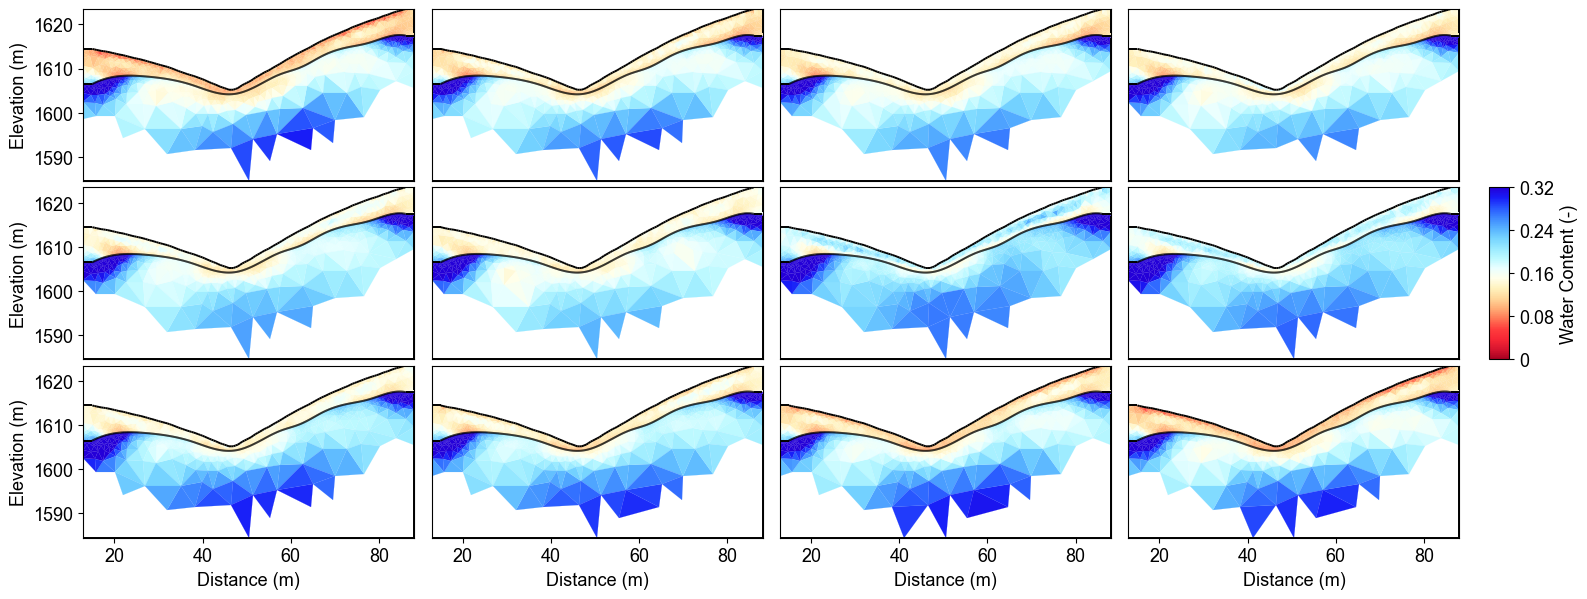

In [11]:
from palettable.lightbartlein.diverging import BlueDarkRed18_18_r
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pylab as pylab
params = {'legend.fontsize': 13,
          #'figure.figsize': (15, 5),
         'axes.labelsize': 13,
         'axes.titlesize':13,
         'xtick.labelsize':13,
         'ytick.labelsize':13}

pylab.rcParams.update(params)
plt.rcParams["font.family"] = "Arial"

fixed_cmap = BlueDarkRed18_18_r.mpl_colormap
fig = plt.figure(figsize=[16, 6])

# Use tight_layout with adjusted parameters to reduce space
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# True resistivity model
for i in range(12):
    row, col = i // 4, i % 4
    ax = fig.add_subplot(3, 4, i+1)
    
    # Add common ylabel only to leftmost panels
    ylabel = "Elevation (m)" if col == 0 else None
    
    # Add resistivity label only to the middle-right panel (row 1, col 3)
    resistivity_label = ' Resistivity ($\Omega$ m)' if (i == 7) else None
    
    # Only show axis ticks on leftmost and bottom panels
    if col != 0:
        ax.set_yticks([])
    
    if row != 2:  # Not bottom row
        ax.set_xticks([])
    else:
        # Add "distance (m)" label to bottom row panels
        ax.set_xlabel("Distance (m)")
    
    # Create the plot
    ax, cbar = pg.show(mesh,
                      water_content_mean[:, i],
                      pad=0.3,
                      orientation="vertical",
                      cMap=fixed_cmap,
                      cMin=0,
                      cMax=0.32,
                      ylabel=ylabel,
                      label= 'Water Content (-)',
                      ax=ax,
                      logScale=False,
                      coverage=coverage[i,:]>-1.2)
    
    # Only keep colorbar for the middle-right panel (row 1, col 3)
    # This corresponds to panel index 7 in a 0-based indexing system
    if i != 7:  # Keep only the colorbar for panel 7
        cbar.remove()

plt.tight_layout()
plt.savefig("results/Structure_WC/timelapse_sat.tiff", dpi=300, bbox_inches='tight')

In [4]:
WC_true = []

for i in np.arange(30,361,30):
    # Extract true water content values for the current timestep
    true_values = np.load("results/TL_measurements/synwcmodel/synwcmodel"+str(i)+".npy")
      
    # Store the true values for this timestep
    WC_true.append(true_values)
mesh_true = pg.load("results/TL_measurements/mesh.bms")
WC_true = np.array(WC_true)
print(WC_true.shape)

(12, 10664)


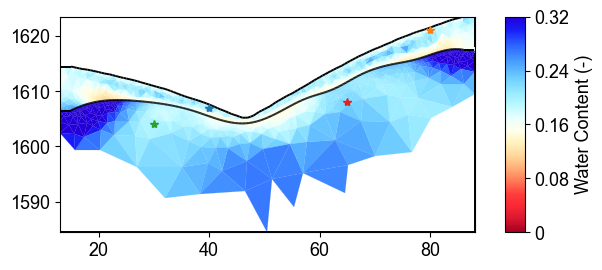

In [5]:
fig = plt.figure(figsize=[6, 3])
ax = fig.add_subplot(1, 1, 1)
ax, cbar = pg.show(mesh,
                water_content_mean[:, 6],
                pad=0.3,
                orientation="vertical",
                cMap=fixed_cmap,
                cMin=0,
                cMax=0.32,
                ylabel=ylabel,
                label= 'Water Content (-)',
                ax=ax,
                logScale=False,
                coverage=coverage[6,:]>-1.2)

ax.plot([40],[1607],'*')
ax.plot([80],[1621],'*')

ax.plot([30],[1604],'*')
ax.plot([65],[1608],'*')

In [6]:
# Modified function to extract time series based on x AND y positions
def extract_mc_time_series(mesh, values_all, positions):
    """
    Extract Monte Carlo time series at specific x,y positions
    
    Args:
        mesh: PyGIMLI mesh
        values_all: Array of all Monte Carlo realizations (n_realizations, n_cells, n_timesteps)
        positions: List of (x,y) coordinate tuples
        
    Returns:
        time_series: Array of shape (n_positions, n_realizations, n_timesteps)
        cell_indices: List of cell indices corresponding to the positions
    """
    n_realizations = values_all.shape[0]
    n_timesteps = values_all.shape[2]
    
    # Find indices of cells closest to specified positions
    cell_indices = []
    for x_pos, y_pos in positions:
        # Calculate distance from each cell center to the position
        cell_centers = np.array(mesh.cellCenters())
        distances = np.sqrt((cell_centers[:, 0] - x_pos)**2 + (cell_centers[:, 1] - y_pos)**2)
        cell_idx = np.argmin(distances)
        cell_indices.append(cell_idx)
    
    # Extract time series for each realization and position
    time_series = np.zeros((len(positions), n_realizations, n_timesteps))
    
    for pos_idx, cell_idx in enumerate(cell_indices):
        for mc_idx in range(n_realizations):
            time_series[pos_idx, mc_idx, :] = values_all[mc_idx, cell_idx, :]
    
    return time_series, cell_indices


def extract_true_values_at_positions(mesh, true_values, positions):
    """
    Extract true water content values at specific x,y positions.
    
    Args:
        mesh: PyGIMLI mesh
        true_values: Array of true water content values (n_cells, n_timesteps) or (n_cells,)
        positions: List of (x,y) coordinate tuples
        
    Returns:
        true_values_at_positions: Values at each position
        cell_indices: List of cell indices corresponding to the positions
    """
    # Find indices of cells closest to specified positions
    cell_indices = []
    for x_pos, y_pos in positions:
        # Calculate distance from each cell center to the position
        cell_centers = np.array(mesh.cellCenters())
        distances = np.sqrt((cell_centers[:, 0] - x_pos)**2 + (cell_centers[:, 1] - y_pos)**2)
        cell_idx = np.argmin(distances)
        cell_indices.append(cell_idx)
    
    # Extract true values at the specified positions
    if true_values.ndim == 1:  # Single value per cell
        true_values_at_positions = true_values[cell_indices]
    elif true_values.ndim == 2:  # Time series per cell
        true_values_at_positions = true_values[cell_indices, :]
    else:
        raise ValueError("Unexpected shape for true_values")
    
    return true_values_at_positions, cell_indices



In [7]:

# Define positions to sample (x,y coordinates)
positions = [
    (80, 1621),  # Example coordinates, adjust based on your model
    (40, 1607),
]

# Extract time series data for these positions
time_series_data, cell_indices = extract_mc_time_series(mesh, water_content_all, positions)
Pos1_true, _ = extract_true_values_at_positions(mesh_true, WC_true.T, positions)
Pos1_true

array([[0.08097493, 0.1418029 , 0.15169074, 0.1602892 , 0.16125829,
        0.15085966, 0.19855799, 0.19492963, 0.14982612, 0.13781302,
        0.10646818, 0.08267117],
       [0.1031926 , 0.13886836, 0.15270618, 0.17643507, 0.15142438,
        0.15627901, 0.19532394, 0.18606532, 0.1503809 , 0.13288194,
        0.11554453, 0.10819158]])

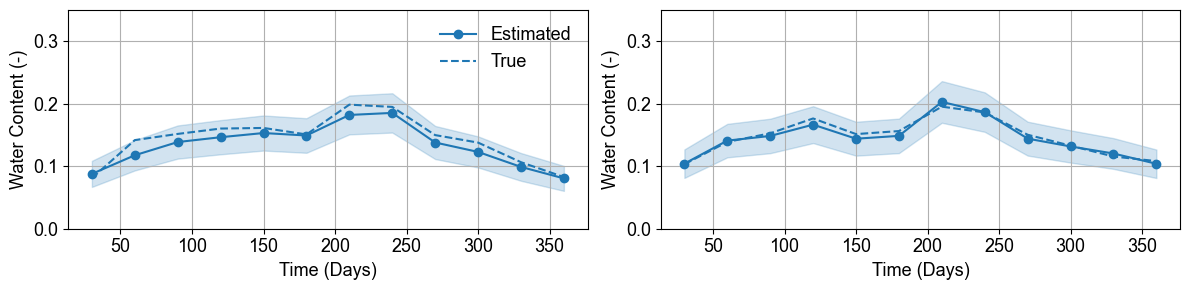

In [8]:
# Plot time series with uncertainty bands
plt.figure(figsize=(12, 3))

measurement_times = np.arange(30,361,30)  # Assuming sequential timesteps


# Calculate statistics
mean_ts = np.mean(time_series_data[0], axis=0)
std_ts = np.std(time_series_data[0], axis=0)

plt.subplot(1, 2, 1)
plt.plot(measurement_times, mean_ts, 'o-', color='tab:blue', label='Estimated')
plt.fill_between(measurement_times, mean_ts-std_ts, mean_ts+std_ts, color='tab:blue', alpha=0.2)
plt.plot(measurement_times,Pos1_true[0, :], 'tab:blue',ls='--', label='True')
plt.grid(True)
plt.legend(frameon=False)
plt.xlabel('Time (Days)')
plt.ylabel('Water Content (-)')
plt.ylim(0, 0.35)
plt.subplot(1, 2, 2)
mean_ts = np.mean(time_series_data[1], axis=0)
std_ts = np.std(time_series_data[1], axis=0)
plt.plot(measurement_times, mean_ts, 'o-', color='tab:blue',)
plt.fill_between(measurement_times, mean_ts-std_ts, mean_ts+std_ts, color='tab:blue', alpha=0.2)
plt.plot(measurement_times,Pos1_true[1, :], 'tab:blue',ls='--')
plt.xlabel('Time (Days)')
plt.ylabel('Water Content (-)')
plt.ylim(0, 0.35)
# plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/Structure_WC/regolith_WC.tiff", dpi=300, bbox_inches='tight')

In [9]:
### Fractured bedrock layer

# Define positions to sample (x,y coordinates)
positions = [
    (30, 1604),  # Example coordinates, adjust based on your model
    (65, 1608),
]

# Extract time series data for these positions
time_series_data2, cell_indices = extract_mc_time_series(mesh, water_content_all, positions)
Pos2_true, _ = extract_true_values_at_positions(mesh_true, WC_true.T, positions)
Pos2_true

array([[0.13900906, 0.13547279, 0.1329891 , 0.13214048, 0.13598835,
        0.14280648, 0.1564236 , 0.1622005 , 0.1654367 , 0.15132865,
        0.14727957, 0.1449224 ],
       [0.13911318, 0.13543656, 0.13259384, 0.13040086, 0.13264936,
        0.13840835, 0.15002008, 0.1623058 , 0.16410032, 0.15118506,
        0.14593856, 0.14431303]])

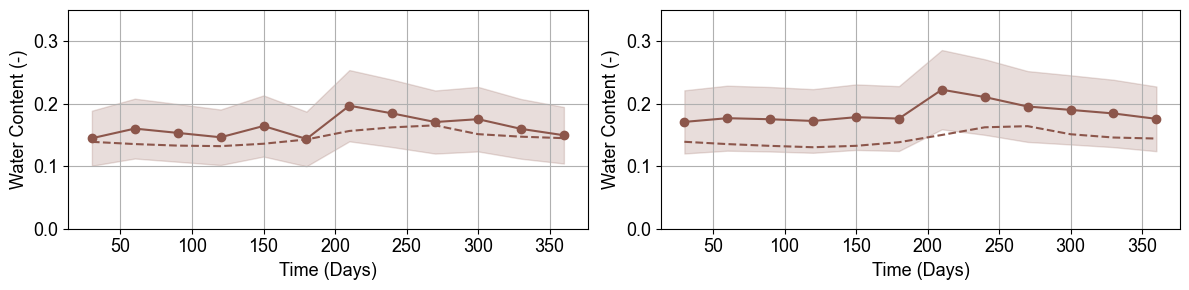

In [10]:
# Plot time series with uncertainty bands
plt.figure(figsize=(12, 3))

measurement_times = np.arange(30,361,30)  # Assuming sequential timesteps


# Calculate statistics
mean_ts = np.mean(time_series_data2[0], axis=0)
std_ts = np.std(time_series_data2[0], axis=0)

plt.subplot(1, 2, 1)
plt.plot(measurement_times, mean_ts, 'o-', color='tab:brown', label='Estimated')
plt.fill_between(measurement_times, mean_ts-std_ts, mean_ts+std_ts, color='tab:brown', alpha=0.2)
plt.plot(measurement_times,Pos2_true[0, :], 'tab:brown',ls='--', label='True')
plt.grid(True)
#plt.legend(frameon=False)
plt.xlabel('Time (Days)')
plt.ylabel('Water Content (-)')
plt.ylim(0, 0.35)
plt.subplot(1, 2, 2)
mean_ts = np.mean(time_series_data2[1], axis=0)
std_ts = np.std(time_series_data2[1], axis=0)
plt.plot(measurement_times, mean_ts, 'o-', color='tab:brown',)
plt.fill_between(measurement_times, mean_ts-std_ts, mean_ts+std_ts, color='tab:brown', alpha=0.2)
plt.plot(measurement_times,Pos2_true[1, :], 'tab:brown',ls='--')
plt.xlabel('Time (Days)')
plt.ylabel('Water Content (-)')
plt.ylim(0, 0.35)
# plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("results/Structure_WC/Fracture_WC.tiff", dpi=300, bbox_inches='tight')